## XGBoost

In [ ]:
import re
import sys
import os

import numpy as np
from tqdm import tqdm
import pandas as pd
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import optuna

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

sys.path.append(os.path.abspath(os.path.join("..")))
from utils import calc_metrics

Загрузим данные которые были предобработаны в ноутбуке `min_baseline.ipynb`.

In [55]:
X = pd.read_csv("../data/x.csv", index_col="date")
y = pd.read_csv("../data/y.csv", index_col="date").iloc[:, 0]

Предобработаем тексты пресс-релизов.

In [ ]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words("russian"))
def preprocessor(text):
    text = text.lower()
    regex = re.compile("[^а-я А-ЯЁё]")
    text = regex.sub(" ", text)
    text = " ".join(mystem.lemmatize(text))
    text = " ".join([word for word in text.split() if word not in STOP_WORDS])
    return text

vectorizer = TfidfVectorizer(
    preprocessor=preprocessor,
)
tf_idf = vectorizer.fit_transform(X.release)

Предобработаем таргет для XGBoost, нужно чтобы значения были 0, 1, 2

In [ ]:
le = LabelEncoder()
y_le = le.fit_transform(y)

Сначала попробуем подобрать гиперпараметры вручную с помощью валидационной выборки, посмотрим на графики ошибки

100%|██████████| 5/5 [14:23<00:00, 172.77s/it]


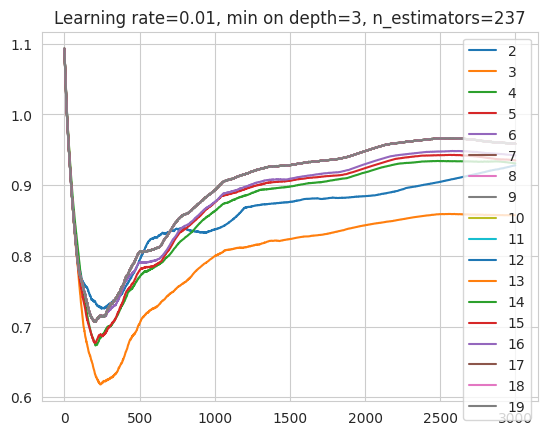

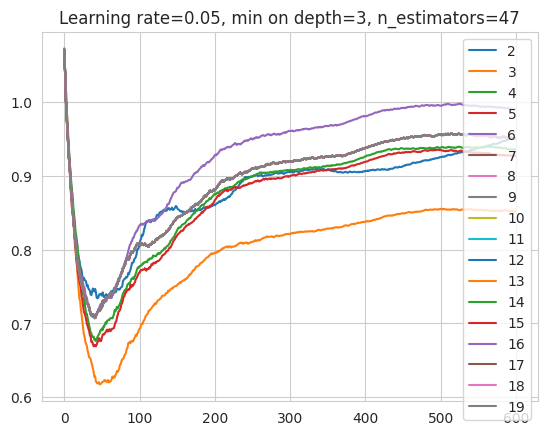

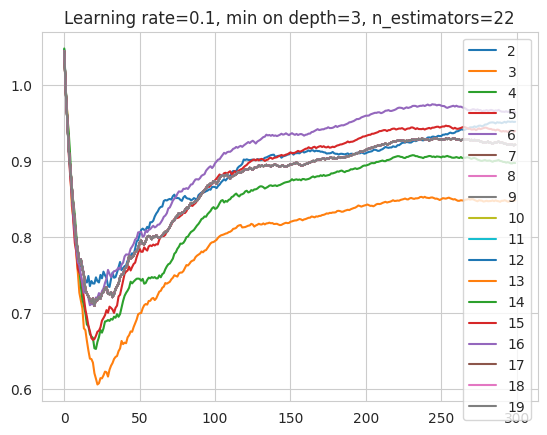

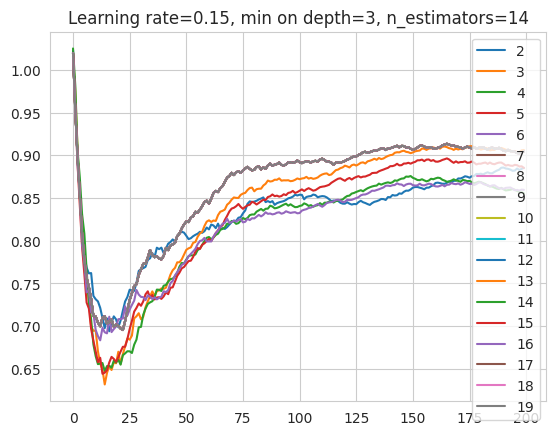

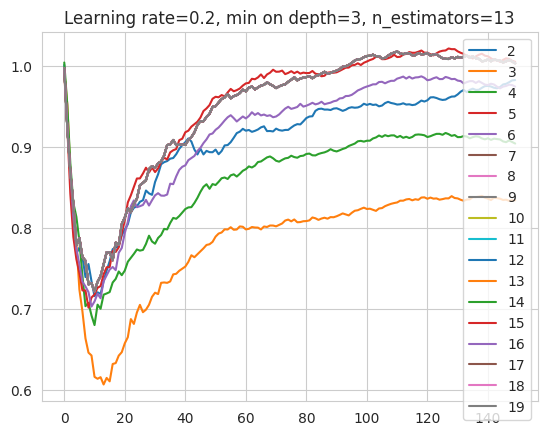

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(tf_idf, y_le, test_size=0.1, random_state=42)
best_params = []
for lr in tqdm([0.01, 0.05, 0.1, 0.15, 0.2]):
    res = []
    for depth in range(2, 20):
        model = XGBClassifier(
            max_depth=depth,
            learning_rate=lr,
            n_estimators=int(30 / lr),
            random_state=42
        )
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        res.append(model.evals_result_['validation_0']['mlogloss'])
    res_arr = np.array(res)
    ij_min = np.unravel_index(res_arr.argmin(), res_arr.shape)
    best_params.append({'lr': lr, 'depth': ij_min[0] + 2, 'n_estimators': ij_min[1], 'mlogloss': res_arr[ij_min[0], ij_min[1]]})
    pd.DataFrame(res_arr.T, columns=range(2, 20)).plot(
        title=f"Learning rate={lr}, min on depth={ij_min[0] + 2}, n_estimators={ij_min[1]}"
        )


In [151]:
df_best_params = pd.DataFrame(best_params)
df_best_params

,lr,depth,n_estimators,mlogloss
0,0.01,3,237,0.618138
1,0.05,3,47,0.617403
2,0.10,3,22,0.605304
3,0.15,3,14,0.631588
4,0.20,3,13,0.607112


              precision    recall  f1-score   support

           0       0.65      0.65      0.65        23
           1       0.52      0.65      0.58        26
           2       0.75      0.47      0.58        19

    accuracy                           0.60        68
   macro avg       0.64      0.59      0.60        68
weighted avg       0.63      0.60      0.60        68



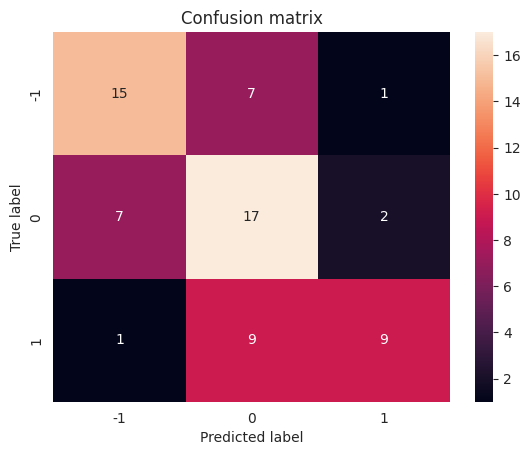

In [163]:
min_best_param = df_best_params[df_best_params['mlogloss'] == df_best_params['mlogloss'].min()]
model = XGBClassifier(
    max_depth=min_best_param['depth'].values[0],
    learning_rate=min_best_param['lr'].values[0],
    n_estimators=min_best_param['n_estimators'].values[0],
    random_state=42
)
metrics, model = calc_metrics(
    tf_idf,
    y_le,
    model,
    name="TF-IDF XGBoost"
)

In [162]:
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
TF-IDF XGBoost,0.602941,0.60303,0.593235,0.639108,0.73294,0.738104


In [ ]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
    }
    model = XGBClassifier(
        max_depth=params["max_depth"],
        learning_rate=params["learning_rate"],
        n_estimators=params["n_estimators"],
        random_state=42,
        n_jobs=-1,
    )
    metric, _ = calc_metrics(tf_idf, y_le, model, name=" ", plot=False)
    return metric


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [140]:
study.best_params

{'max_depth': 2, 'n_estimators': 16, 'learning_rate': 0.23246365821082934}

Обучим модель с лучшими гиперпараметрами и посмотрим на качество.

In [ ]:
model = XGBClassifier(
    max_depth=study.best_params["max_depth"],
    learning_rate=study.best_params["learning_rate"],
    n_estimators=study.best_params["n_estimators"],
    random_state=42,
)

              precision    recall  f1-score   support

           0       0.76      0.70      0.73        23
           1       0.53      0.65      0.59        26
           2       0.67      0.53      0.59        19

    accuracy                           0.63        68
   macro avg       0.65      0.63      0.63        68
weighted avg       0.65      0.63      0.63        68



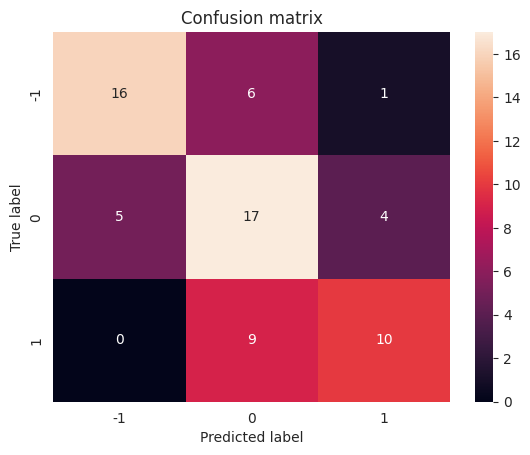

In [142]:
# вычисляем метрики
metrics, model = calc_metrics(
    tf_idf,
    y_le,
    model,
    name="TF-IDF XGBoost"
)

In [143]:
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
TF-IDF XGBoost,0.632353,0.633905,0.625271,0.653274,0.766337,0.771152


Optuna помогла нам подобрать параметры лучше. Но тем не менее, побить лучшую линейную модель не удалось.